In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("Acidentes_DadosAbertos_20240902.csv", encoding="UTF-8", delimiter=";")

C:\Users\jai_m\AppData\Local\Temp\ipykernel_8864\662764081.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Acidentes_DadosAbertos_20240902.csv", encoding="UTF-8", delimiter=";")


In [12]:
df = df[df['uf_acidente'] == "BA"]
df

,num_acidente,chv_localidade,data_acidente,uf_acidente,ano_acidente,mes_acidente,mes_ano_acidente,codigo_ibge,dia_semana,fase_dia,...,lim_velocidade,tp_pista,ind_guardrail,ind_cantcentral,ind_acostamento,qtde_acidente,qtde_acid_com_obitos,qtde_envolvidos,qtde_feridosilesos,qtde_obitos
47054,1596736,BA2913606201801,2018-01-14,BA,2018,1,12018,2913606,DOMINGO,TARDE,...,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,1,0,1,1,0
47055,4001553,BA2921005201801,2018-01-21,BA,2018,1,12018,2921005,DOMINGO,TARDE,...,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,1,0,2,2,0
47056,5559367,BA2932903201801,2018-01-18,BA,2018,1,12018,2932903,QUINTA-FEIRA,MANHA,...,NAO INFORMADO,NAO INFORMADO,NAO,NAO INFORMADO,NAO INFORMADO,1,0,1,1,0
47057,2376786,BA2924009201801,2018-01-22,BA,2018,1,12018,2924009,SEGUNDA-FEIRA,TARDE,...,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,1,0,2,2,0
47058,347393,BA2918357201801,2018-01-28,BA,2018,1,12018,2918357,DOMINGO,MANHA,...,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,1,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137809,5072725,BA0000000202405,2024-05-12,BA,2024,5,52024,0,DOMINGO,NOITE,...,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,1,0,1,1,0
137810,4390618,BA0000000202405,2024-05-20,BA,2024,5,52024,0,SEGUNDA-FEIRA,MANHA,...,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,1,0,1,1,0
137811,4030436,BA0000000202405,2024-05-01,BA,2024,5,52024,0,QUARTA-FEIRA,NOITE,...,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,1,0,1,1,0
137812,2316492,BA0000000202405,2024-05-11,BA,2024,5,52024,0,SABADO,MANHA,...,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,1,0,1,1,0


In [13]:
# Remover colunas irrelevantes
colunas_remover = ['num_acidente', 'chv_localidade', 'data_acidente', 'ano_acidente', 'mes_ano_acidente', 'codigo_ibge', 'uf_acidente', 'end_acidente', 'cep_acidente', 'bairro_acidente', 'km_via_acidente', 'latitude_acidente', 'longitude_acidente', 'ind_guardrail', 'ind_cantcentral', 'ind_acostamento']
df.drop(columns=colunas_remover, inplace=True)


In [14]:
# Preenchendo valores desconhecidos ou não informados
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [15]:
# Codificação de variáveis categóricas
label_encoders = {}
for col in df_imputed.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col])
    label_encoders[col] = le

In [16]:
# Criar variável alvo baseada na severidade do acidente
def categorizar_severidade(row):
    if row['qtde_obitos'] >= 3 or row['qtde_feridosilesos'] > 11:
        return 'Grave'
    elif row['qtde_obitos'] in [1, 2] or (3 <= row['qtde_feridosilesos'] <= 10):
        return 'Moderado'
    elif row['qtde_feridosilesos'] in [1, 2]:
        return 'Leve'
    else:
        return 'Leve'

In [17]:
df_imputed['severidade'] = df_imputed.apply(categorizar_severidade, axis=1)

In [18]:

# Definir features e target
y = df_imputed['severidade']
X = df_imputed.drop(columns=['qtde_acid_com_obitos', 'qtde_obitos', 'qtde_feridosilesos', 'severidade'])

In [19]:
# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Modelos
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'RBF Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', solver='adam', max_iter=500, random_state=42),
    'BP Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=500, random_state=42)
}

In [21]:
# Treinamento e avaliação
desempenho = {}
for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    desempenho[nome] = acc
    print(f'\nModelo: {nome}')
    print(f'Acurácia: {acc:.4f}')
    print(classification_report(y_test, y_pred))


Modelo: Random Forest
Acurácia: 0.9320
              precision    recall  f1-score   support

       Grave       0.88      0.56      0.68        50
        Leve       0.94      0.98      0.96     15137
    Moderado       0.87      0.68      0.77      2965

    accuracy                           0.93     18152
   macro avg       0.90      0.74      0.80     18152
weighted avg       0.93      0.93      0.93     18152


Modelo: SVM
Acurácia: 0.9441
              precision    recall  f1-score   support

       Grave       0.87      0.52      0.65        50
        Leve       0.94      1.00      0.97     15137
    Moderado       0.99      0.67      0.80      2965

    accuracy                           0.94     18152
   macro avg       0.93      0.73      0.80     18152
weighted avg       0.95      0.94      0.94     18152


Modelo: RBF Neural Network
Acurácia: 0.9444
              precision    recall  f1-score   support

       Grave       0.86      0.60      0.71        50
        Leve  

Importância das Variáveis:
qtde_envolvidos: 0.5621
hora_acidente: 0.1742
mes_acidente: 0.0692
cond_pista: 0.0481
tp_acidente: 0.0411
dia_semana: 0.0389
tp_pista: 0.0214
tp_rodovia: 0.0156
tp_pavimento: 0.0136
fase_dia: 0.0102
cond_meteorologica: 0.0056
qtde_acidente: 0.0000
lim_velocidade: 0.0000
tp_curva: 0.0000
tp_cruzamento: 0.0000
num_end_acidente: 0.0000


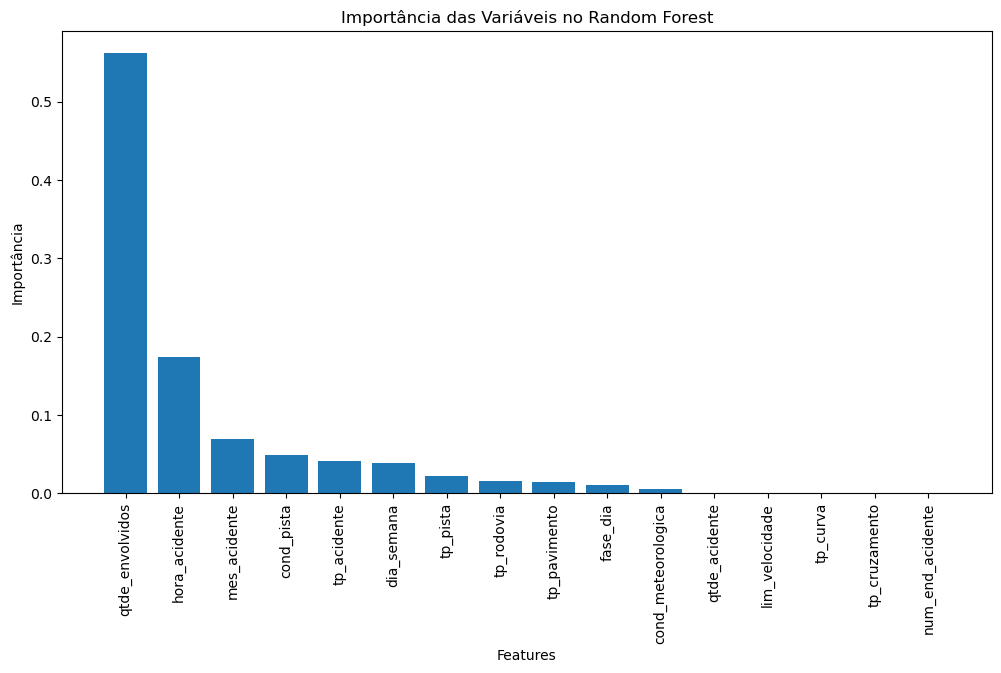

In [27]:
importances = modelos['Random Forest'].feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

print("Importância das Variáveis:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importância")
plt.title("Importância das Variáveis no Random Forest")
plt.show()